In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
from os.path import join, exists
import copy
import matplotlib.pyplot as plt

import sys
import os
# sys.path.append('../dataset/safegraph/utils/')
sys.path.append('../')

from dataset_classes import * 
from models import *
from helper_funcs import *

/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
root = '/mnt/e/julia/regional-representations-graph-model/'

sys.path.append(root + 'utils/')
from utils import *

scenario = 'all_valid_data/'
print(f'Env Var Scenario: {scenario}')
node_list_path= root + f'dataset/preprocessed_data/{scenario}node_list.csv'

earth_engine_filename = 'least_cloudy_m6_m10_rectangle_highres.tif'
fn = earth_engine_filename

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
landsat_model = ResNetTransform(device)

root + 'dataset/earth_engine/download_landsat_images'

Env Var Scenario: all_valid_data/


'/mnt/e/julia/regional-representations-graph-model/dataset/earth_engine/download_landsat_images'

In [3]:
datasets1 = SatelliteImageryDataset(node_list_path=node_list_path, 
                                        root_image_dir=root + 'dataset/earth_engine/download_landsat_images', 
                                        fn=fn, is_train=True, transform=landsat_model, 
                                        load_embeddings=False)

In [4]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model = landsat_model.resnet18
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

In [6]:
def show_and_return_satellite_image(satellite_dataset, idx=0, is_print_pixels=True):
    img = satellite_dataset.__getsampletest__(idx)
    mod = img.transpose(1, 2, 0)
    mod[mod == -np.inf] = np.nan

    mod1 = make_color_image_eqh(mod[:,:,0], mod[:,:,1], mod[:,:,2])
    plt.figure()
    plt.imshow(mod1)
    # plt.title(geoid)
    
    if is_print_pixels == True:
        npixels = img.shape[0] * img.shape[1]
        print(npixels)
        
    return img

def plot_feature_map(image):
    outputs = []
    names = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))


    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())

    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i], vmax=np.percentile(processed[i], 98), vmin=np.percentile(processed[i], 2))
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)

In [7]:
def transform(img):
    x = img
    x = torch.tensor(x)
    x = torch.nan_to_num(x, 0, 0, 0)
    x = x.to(landsat_model.device)
    x = landsat_model.transforms(x)
    x = torch.unsqueeze(x, 0)
    image = x
    return image

87
17


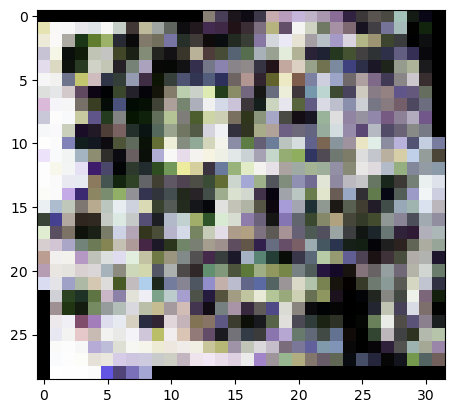

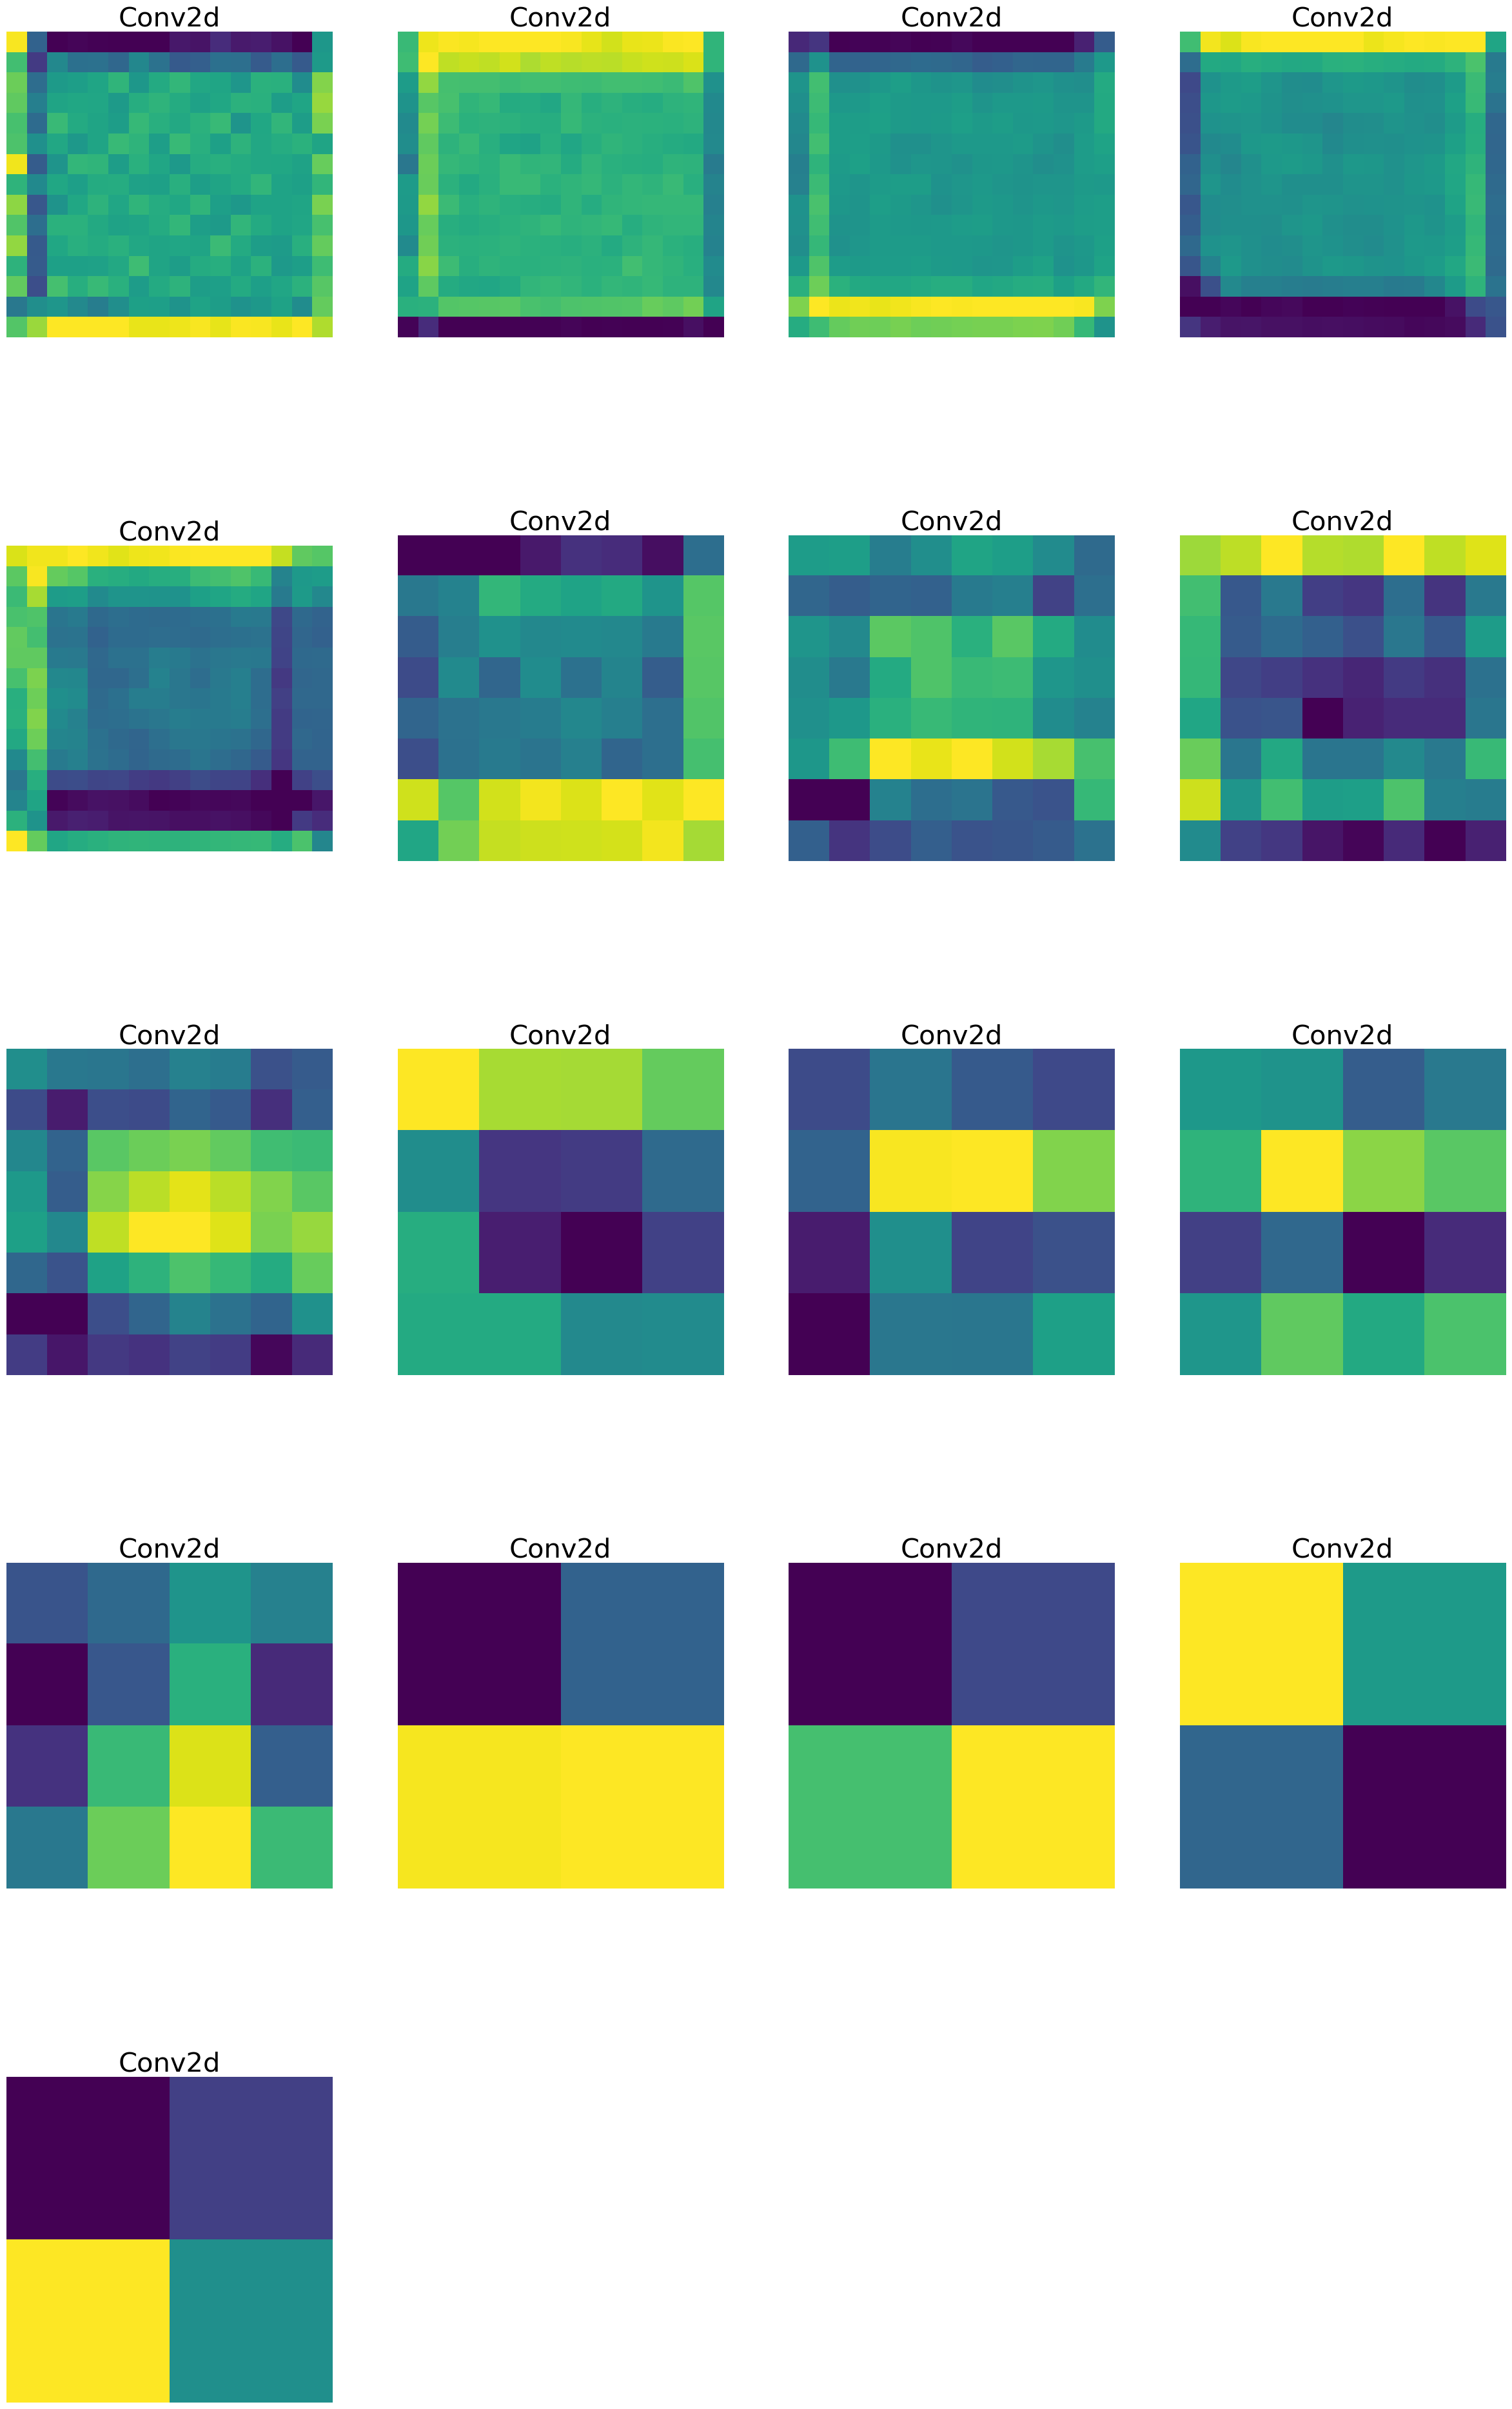

In [8]:
img = show_and_return_satellite_image(datasets1, idx=0)
image = transform(img)
plot_feature_map(image)

738
17


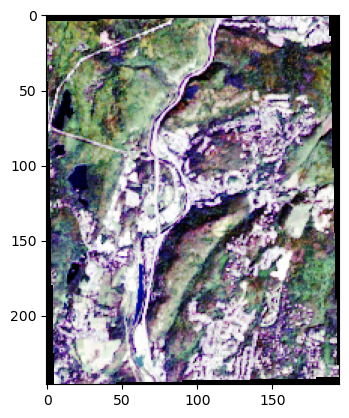

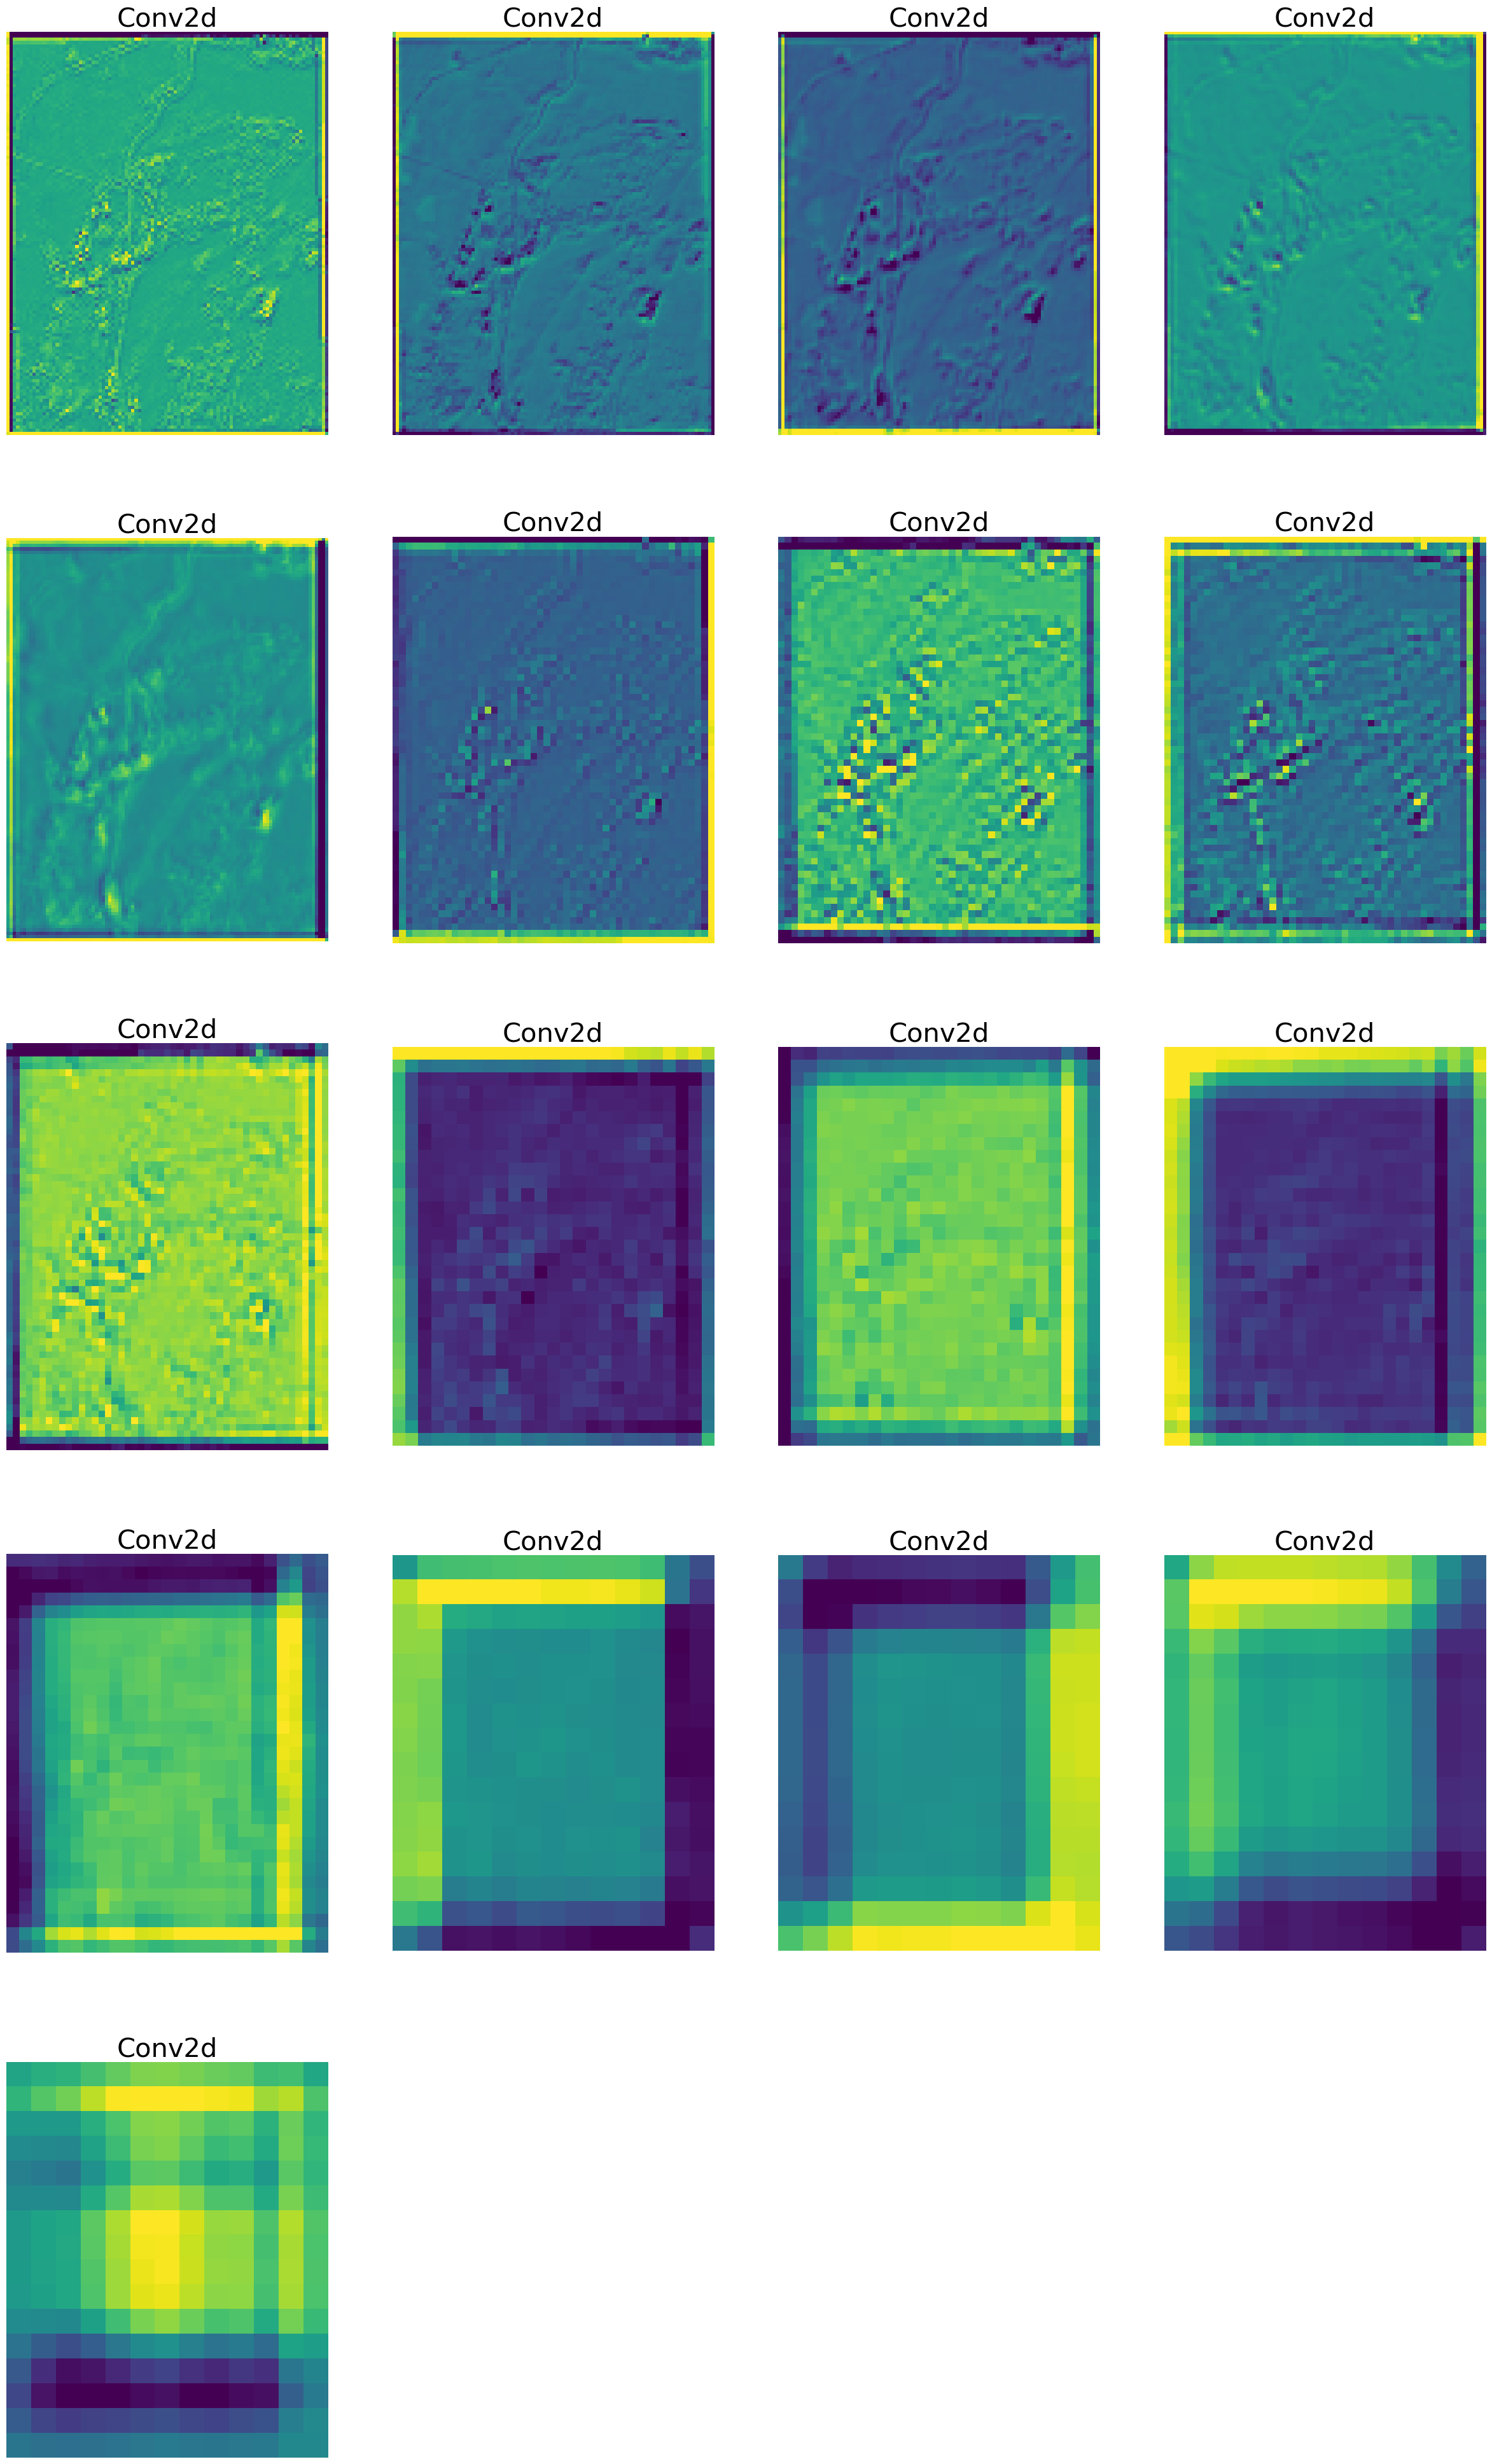

In [9]:
img = show_and_return_satellite_image(datasets1, idx=7)
image = transform(img)
plot_feature_map(image)

564
17


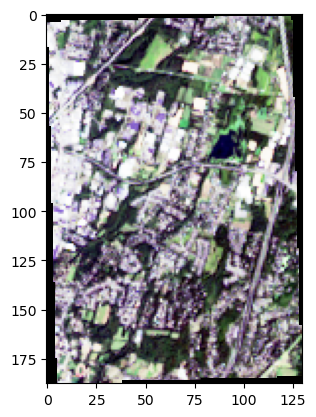

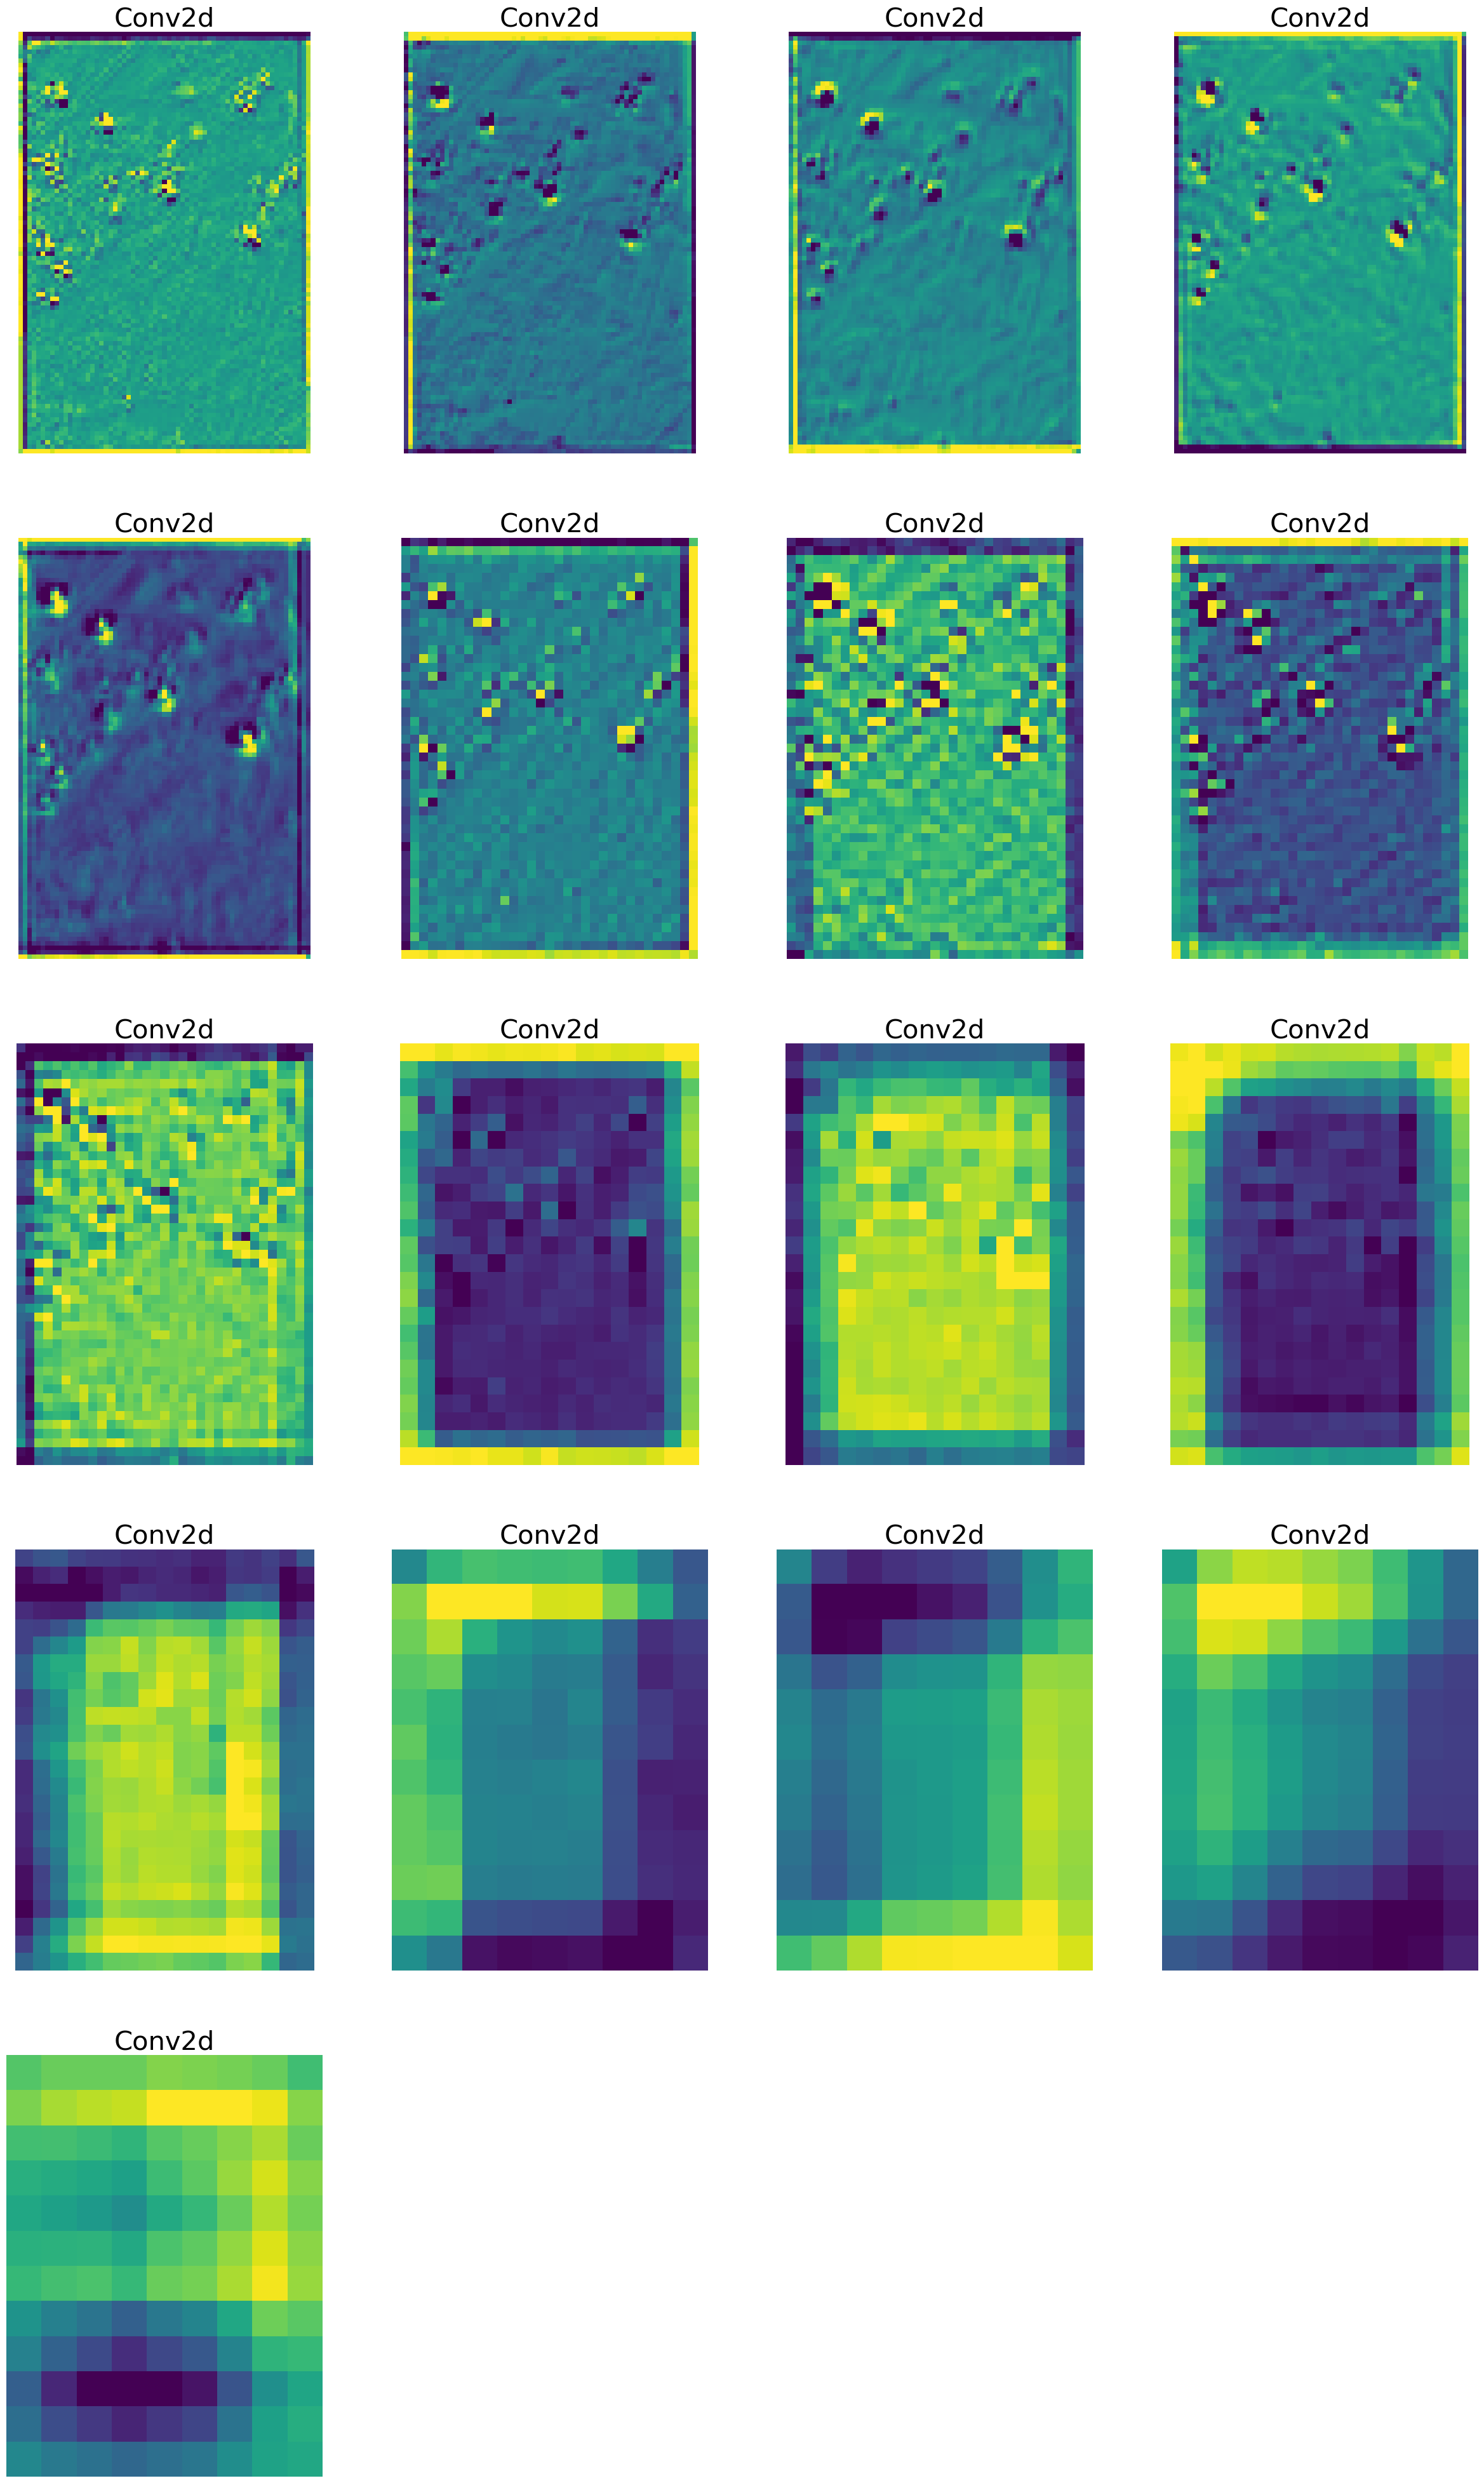

In [14]:
img = show_and_return_satellite_image(datasets1, idx=50)
image = transform(img)
plot_feature_map(image)